# Sonarski lantarn detection Detectron2

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

Run the commands manually in your terminal if it does not work.

In [1]:
# !conda install pytorch torchvision torchaudio cpuonly -c pytorch
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git
# !pip install opencv-python
# !conda install jupyter
# !pip install pandas

# OPTIONAL
# !pip3 install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio===0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

## Get data

In [2]:
classes = ['lantarn A', 'lantarn head A']
image_folder = "images"
croppped_images_folder = "cropped_masks"
video_path = "videos/OmersA.mp4"

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import pandas as pd

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_microcontroller_dicts(directory):
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["image_id"] = idx
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("microcontroller_" + d, lambda d=d: get_microcontroller_dicts(image_folder + '/' + d))
    MetadataCatalog.get("microcontroller_" + d).set(thing_classes=classes)
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

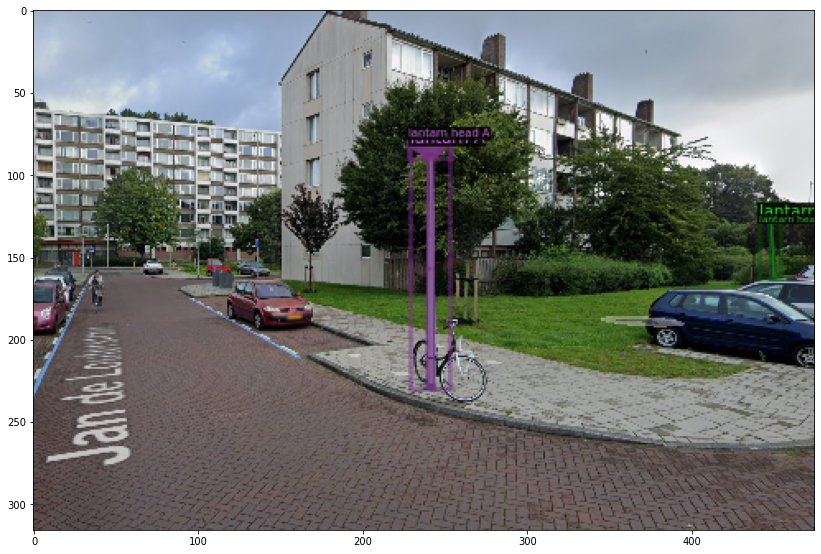

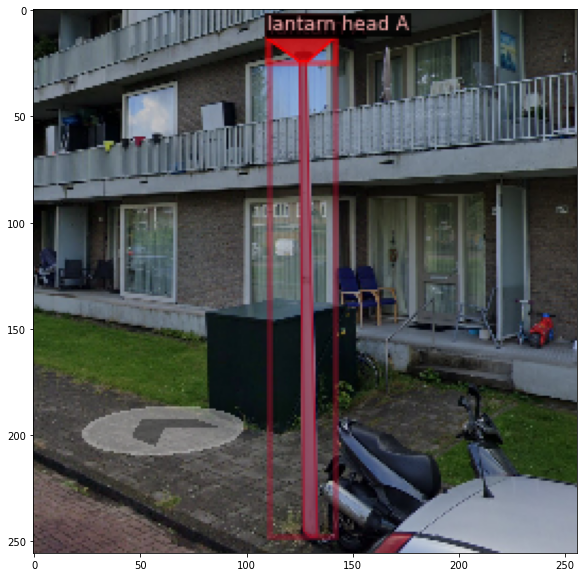

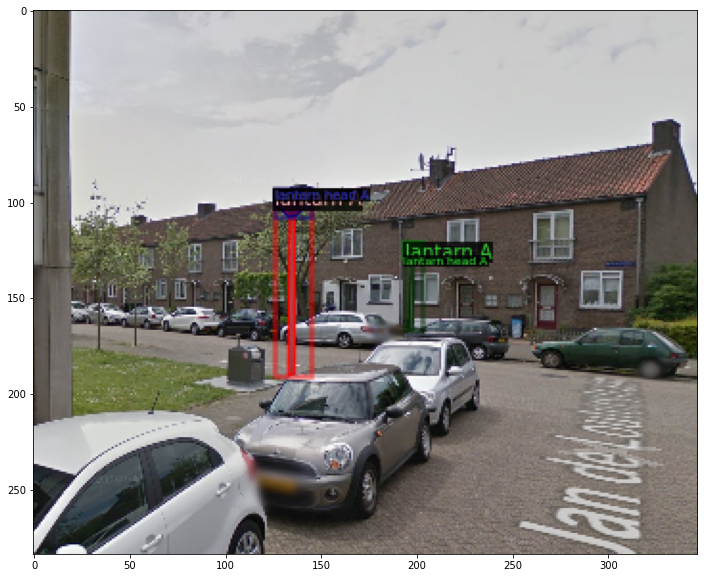

In [5]:
import random

dataset_dicts = get_microcontroller_dicts(image_folder + "/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/27 20:19:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[01/27 20:19:35 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\omerb\anaconda3\envs\d2new\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/27 20:20:12 d2.utils.events]:  eta: 0:08:50  iter: 19  total_loss: 2.515  loss_cls: 1.258  loss_box_reg: 0.01375  loss_mask: 0.6887  loss_rpn_cls: 0.4454  loss_rpn_loc: 0.0771  time: 1.2008  data_time: 0.2722  lr: 9.7405e-06  max_mem: 2422M
[01/27 20:20:36 d2.utils.events]:  eta: 0:08:24  iter: 39  total_loss: 2.08  loss_cls: 1.021  loss_box_reg: 0.0177  loss_mask: 0.6733  loss_rpn_cls: 0.3096  loss_rpn_loc: 0.09172  time: 1.2098  data_time: 0.0023  lr: 1.9731e-05  max_mem: 2422M
[01/27 20:20:58 d2.utils.events]:  eta: 0:08:01  iter: 59  total_loss: 1.663  loss_cls: 0.6402  loss_box_reg: 0.03791  loss_mask: 0.6432  loss_rpn_cls: 0.2075  loss_rpn_loc: 0.06009  time: 1.1739  data_time: 0.0016  lr: 2.972e-05  max_mem: 2422M
[01/27 20:21:21 d2.utils.events]:  eta: 0:07:39  iter: 79  total_loss: 1.168  loss_cls: 0.3878  loss_box_reg: 0.05149  loss_mask: 0.5987  loss_rpn_cls: 0.1177  loss_rpn_loc: 0.04922  time: 1.1611  data_time: 0.0015  lr: 3.9711e-05  max_mem: 2422M
[01/27 20:21:45 d2

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

In [8]:
from detectron2.utils.visualizer import ColorMode
import glob
from DetectorAPI import Detector, blurBoxes
from PIL import Image

# Capture the video
cap = cv2.VideoCapture(video_path)

# While loop status, in case the video has ended
video_status = True

# File index number for the files
file_index = 0

# Remove old cropped mask files
old_cropped_mask_files = glob.glob(f"./{croppped_images_folder}/*")
for file in old_cropped_mask_files:
    os.remove(file)

def save_segmentation(outputs, frame):
    global file_index

    # For each instance in the frame
    for i in range(len(outputs["instances"])):
        # Get the instance
        instance = outputs['instances'][i]

        # Get the instance class name
        instance_class = classes[instance.pred_classes.tolist()[0]]

        # Get the instance predicted mask
        item_mask = np.asarray(instance.pred_masks.to('cpu'))[0]

        # Get the box border values of the predicted mask
        segmentation = np.where(item_mask == True)
        xmin = int(np.min(segmentation[1]))
        xmax = int(np.max(segmentation[1]))
        ymin = int(np.min(segmentation[0]))
        ymax = int(np.max(segmentation[0]))

        # Get the cropped image from the frame
        cropped = Image.fromarray(frame[ymin:ymax, xmin:xmax, :], mode='RGB')

        # Get the PIL image out of the mask
        mask = Image.fromarray((item_mask * 255).astype('uint8'))

        # Get the cropped mask to match the cropped image
        cropped_mask = mask.crop((xmin, ymin, xmax, ymax))

        # Create a new foreground image and paste the image
        new_fg1_image = Image.new('RGB', cropped.size)
        new_fg1_image.paste(cropped)

        # Create a new background cropped image and paste the cropped mask
        new_fg2_image = Image.new('RGB', cropped_mask.size)
        new_fg2_image.paste(cropped_mask)

        # Create a new alpha mask and paste the cropped mask
        new_alpha_mask = Image.new('L', cropped.size, color=0)
        new_alpha_mask.paste(cropped_mask)

        # Compose the cropped foreground images using the alpha mask
        composite = Image.composite(new_fg1_image, new_fg2_image, new_alpha_mask)

        # New image array
        new_image = np.array(composite)

        # Save the image to a file
        filename = f"./{croppped_images_folder}/cropped_{str(file_index)}_{instance_class.replace(' ', '_')}.png"
        file_index += 1
        cv2.imwrite(filename, new_image)

while video_status:
  (ret, frame) = cap.read()
  detector = Detector(model_path='face.pb', name="detection")
  faces = detector.detect_objects(frame, threshold=.5)
  im = blurBoxes(frame, faces)

  # If video has ended, stop the loop
  if frame is None:
      video_status = False
      continue

  outputs = predictor(frame)
  save_segmentation(outputs, frame)

  v = Visualizer(frame[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE
  )

  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2.imshow("Preview", v.get_image()[:, :, ::-1])

  if cv2.waitKey(1) & 0xFF == ord('q'):
      cap.release()
      break
  (ret, frame) = cap.read()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import math

def get_brightness_score(image):
    # Flatten the 2D array into 1D
    flatten_image = image.flatten()

    # Remove the black background from the array
    true_values = flatten_image[flatten_image != 0]

    return {
        "mean": math.floor(true_values.mean()),
        "max_brightness_count": len(flatten_image[flatten_image == 255]),
        "min_brightness_count": len(flatten_image[flatten_image >= 200]),
        "total_count": len(flatten_image),
        "center": image[math.floor(len(image)/2)][math.floor(len(image[0])/2)]
    }

In [ ]:
files = glob.glob(f"./{croppped_images_folder}/*")
head_files = [file for file in files if "head" in file]
df = pd.DataFrame()
for file in head_files:
    img = cv2.imread(file)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    brightness = hsv[:, :, 2]
    df = df.append(get_brightness_score(brightness), ignore_index=True)
    print(file)
    cv2.imwrite(f"{file}-hsv.png", brightness)
    plt.imshow(brightness)
    plt.show()

df.to_csv("analysis.csv")
df

## Plots

In [ ]:
import pandas as pd

day = pd.read_csv("day_analysis.csv")
columns = [col for col in day.columns if col != "total_count" and col != "min_brightness_count"]
day.plot(y=columns[1:])
day.plot(y='total_count')
day.plot(y='min_brightness_count', color='red')

night = pd.read_csv("night_analysis.csv")
columns = [col for col in night.columns if col != "total_count" and col != "min_brightness_count"]
night.plot(y=columns[1:])
night.plot(y='total_count')
night.plot(y='min_brightness_count', color='red')